## Intensity comparison - bic/non-bic - epitope blocking experiments
- <a href='#modules'>Import modules</a>
- <a href='#specifydirectory'>Specify experiment directory</a>
- <a href='#makedict'>Make empty dictionary to store results</a>
- <a href='#makepdfs'>Make PDFs of raw images</a>
- <a href='#loadingprocessinganalysing'>Loading, processing and batch analyzing the images</a>
    - <a href='#preprocessing'>Preprocessing</a>
    - <a href='#segmenting'>Segmenting</a>
- <a href='#quantitativeimageanalysis'>Quantitative image analysis</a>
- <a href='#plots'>Plots</a>
    - <a href='#checknormality'>Check normality</a>
    - <a href='#barplots'>Barplots</a>
    - <a href='#boxwhisker'>Box and whisker plots</a>
    - <a href='#violinplots'>Violin plots</a>
- <a href='#makingsense'>Making sense</a>

<a id='modules'></a> 
### Import modules
These contain all the functions we will be using for the analysis

In [88]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

<a id='specifydirectory'></a> 
### Specify experiment directory
- Experimental conditions are named after the folders in the directory
- Channel numbers of each condition (ECM, synapses, nuclei) is read from the file channels.txt in the directory

In [89]:
expdir='/Volumes/ukps-all$/AG-Rizzoli/Gabriel/' #master folder
protein="NE" #TNR,Agg,WFA,HABP

<a id='makedict'></a> 
### Make an empty dictionary to store all the results we want to calculate

In [90]:
results = {"filename":[],
           "ecmchannelno":[],"nucleichannelno":[],"synapsechannelno":[],"noblock_controldir":[],
           "Soma mask from synapse channel":[],
           "Neurites mask from synapse channel":[],
           "Manual mask from matlab GUI":[],
           "exp condition":[],
           "ECM raw intensity, unmasked":[],
           "Nuclei raw intensity, unmasked":[],
           "Synapse raw intensity, unmasked":[],
           "ECM intensity: unmasked, divded by unblocked condition":[],
           "ECM mean intensity: soma only":[],
           "ECM mean intensity: soma only, divided by unblocked":[],
           "ECM mean intensity: neurites only":[],
           "ECM mean intensity: neurites only, divided by unblocked":[],
           "ECM mean intensity: matlab manual mask only":[],
           "ECM mean intensity: matlab manual mask only, divided by unblocked":[],
           "ECM mean intensity: icy  mask only":[],
           "ECM mean intensity: icy mask only, divided by unblocked":[],
           "Synapse mean intensity: soma only":[],
           "Synapse mean intensity: neurites only":[],
           "Synapse mean intensity: matlab manual mask only":[],
           "Synapse mean intensity: icy mask only":[],
           "Nuclei mean intensity: soma only":[],
           "Nuclei mean intensity: neurites only":[],
           "Nuclei mean intensity: matlab manual mask only":[],
           "Nuclei mean intensity: icy mask only":[],
           "Number of synapse spots in soma mask":[],
           "Number of synapse spots in neurites mask":[],
           "Number of synapse spots in matlab manual mask":[],
           "Number of synapse spots in icy mask":[],
           "Number of nuclei spots in soma mask":[],
           "Number of nuclei spots in neurites mask":[],
           "Number of nuclei spots in matlab manual mask":[],
           "Number of nuclei spots in icy mask":[],
           "ECM mean intensity after bg subtraction: soma only":[],
           "ECM mean intensity after bg subtraction: soma only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: neurites only":[],
           "ECM mean intensity after bg subtraction: neurites only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: matlab manual mask only":[],
           "ECM mean intensity after bg subtraction: matlab manual mask only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: icy mask only":[],
           "ECM mean intensity after bg subtraction: icy mask only, divided by unblocked":[], 
           "Synapse mean intensity after bg subtraction: soma only":[],
           "Synapse mean intensity after bg subtraction: neurites only":[],
           "Synapse mean intensity after bg subtraction: matlab manual mask only":[],
           "Synapse mean intensity after bg subtraction: icy mask only":[],
           "Number of synapse spots in soma mask after bg subtraction":[],
           "Number of synapse spots in neurites mask after bg subtraction":[],
           "Number of synapse spots in matlab manual mask after bg subtraction":[],
           "Number of synapse spots in icy mask after bg subtraction":[],
           "Number of nuclei spots in soma mask after bg subtraction":[],
           "Number of nuclei spots in neurites mask after bg subtraction":[],
           "Number of nuclei spots in matlab manual mask after bg subtraction":[],
          "Number of nuclei spots in icy mask after bg subtraction":[]}
          
histogram_results={"filename":[],"exp condition":[],
                   "ECM raw intensity- Flattened histogram":[],
                   "Nuclei raw intensity- Flattened histogram":[],
                   "Synapse raw intensity- Flattened histogram":[]}
regionprops_results={"filename":[],
                     "exp condition":[],
                     "Synapse colour - regionprops soma":[],
                     "Synapse colour - regionprops neurites":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if (protein in str(filelist[i]))==True:
            if filelist[i].endswith(".nd2"): 
                results["filename"].append(filelist[i])
                histogram_results["filename"].append(filelist[i])
                regionprops_results["filename"].append(filelist[i])
                results["exp condition"].append(filelist[i].split('/')[-2])
                histogram_results["exp condition"].append(filelist[i].split('/')[-2])
                regionprops_results["exp condition"].append(filelist[i].split('/')[-2])
                channeldir="/".join(filelist[i].split("/")[:-2])
                exec(open(channeldir+"/channels.txt").read())
                results["ecmchannelno"].append(ecmchannelno)
                results["nucleichannelno"].append(nucleichannelno)
                results["synapsechannelno"].append(synapsechannelno)
                positivecontrolcheck=Path(channeldir+"/Ctrl_NoBlocking")
                if positivecontrolcheck.exists():
                    results["noblock_controldir"].append(channeldir+"/Ctrl_NoBlocking")                

**Let's take a look at which experimental conditions we have**

In [91]:
print("\n".join(list(sorted(set(results["exp condition"])))))

12hrs_Bic
12hrs_DMSO
2hrs_Bic
2hrs_DMSO
4hrs_Bic
4hrs_DMSO
Ctrl_NoBlocking


<a id='loadingprocessinganalysing'></a> 
## Loading, processing and batch analyzing the images

**Start by loading a random image and looking at the ECM channel:**

Image name: 20181211_NE_10_005.nd2
Experimental condition: 2hrs_DMSO


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text yticklabel objects>)

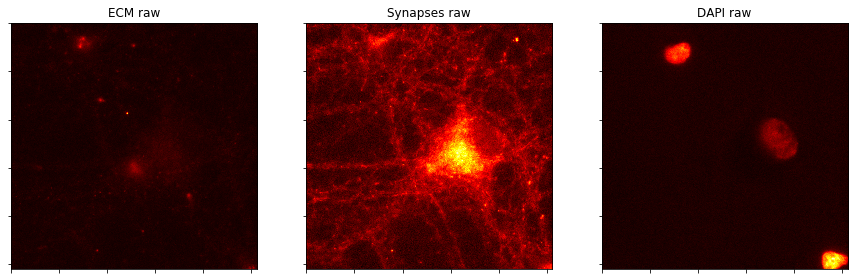

In [92]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]
with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    nuclei_image=images[nuclei_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    ###the part below just checks what filter was used in the microscope for the channels
    ###from the image metadata
    [channel1name, channel2name, channel3name]=ecm_image.metadata['channels']
    if ecm_channel_no==1:
        ecm_channelname=channel1name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel3name
        else:
            nuclei_channelname=channel3name
            synapse_channelname=channel2name
    if ecm_channel_no==2:
        ecm_channelname=channel2name
        if nuclei_channel_no==3:
            nuclei_channelname=channel3name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel3name
    if ecm_channel_no==3:
        ecm_channelname=channel3name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel2name
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(132)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(133)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


### Automatic masking
Make an automatic mask for the image using the synapse channel - 
- Threshold with Li method (minimizing cross entropy)
- Make a separate mask for soma and neurites:
    - Find the soma by labelling the binary mask --> largest connected component = soma
    - Blur soma --> save this as soma mask
    - Blue remaining area --> save this as neurite mask

Run below to see an example of a random image after masking

Text(0.5, 1.0, 'ECM raw image')

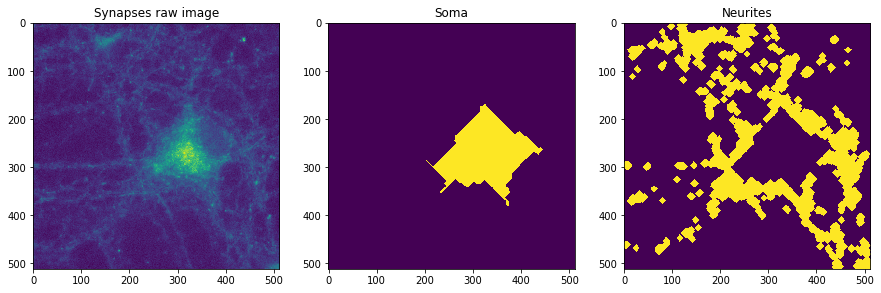

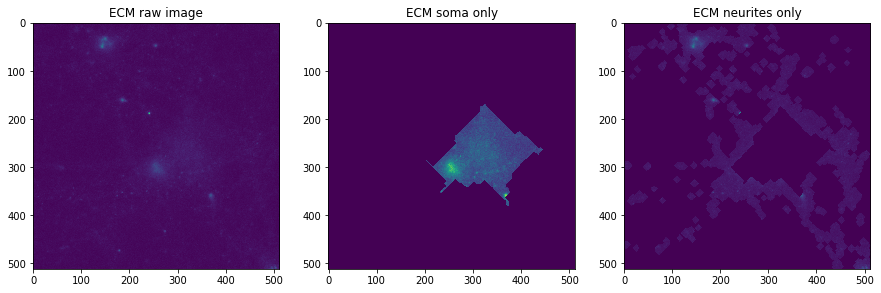

In [93]:
def makemask(synapse_image):
    #li thresholding
    synapse_image_threshold=threshold_li(synapse_image)
    synapse_image_thresholded=deepcopy(synapse_image)
    synapse_image_thresholded[synapse_image_thresholded<synapse_image_threshold]=0
    #find soma + some morphological operations
    synapse_labeled_mask, cc_num = ndi.label(synapse_image_thresholded)
    synapse_largest_cc_mask = (synapse_labeled_mask == (np.bincount(synapse_labeled_mask.flat)[1:].argmax() + 1))
    soma_mask=ndi.binary_closing(ndi.gaussian_filter(synapse_largest_cc_mask,sigma=1),iterations=40)
    #some morphological operations on the neurite mask
    neurite_mask=deepcopy(synapse_image_thresholded)
    neurite_mask[neurite_mask>np.percentile(neurite_mask,99.5)]=0
    neurite_mask[soma_mask]=0
    neurite_mask=ndi.gaussian_filter(neurite_mask,sigma=0.5)
    neurite_mask[neurite_mask>0]=1
    neurite_mask=ndi.binary_erosion(neurite_mask,iterations=4)
    neurite_mask=ndi.binary_dilation(neurite_mask,iterations=7)
    neurite_mask=ndi.binary_fill_holes(neurite_mask)
    return(soma_mask,neurite_mask)
    
#make temporary masked images to show what we will keep
ecm_somamasked=deepcopy(ecm_image)
ecm_neuritemasked=deepcopy(ecm_image)
soma_mask,neurite_mask=makemask(synapse_image)
ecm_somamasked[~soma_mask]=0
ecm_neuritemasked[~neurite_mask]=0
    
#show
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(synapse_image)
plt.title('Synapses raw image')
fig.add_subplot(132)
plt.imshow(soma_mask)
plt.title('Soma')
fig.add_subplot(133)
plt.imshow(neurite_mask)
plt.title('Neurites')

fig=plt.figure(figsize=(15,15))
fig.add_subplot(132)
plt.imshow(ecm_somamasked)
plt.title('ECM soma only')
fig.add_subplot(133)
plt.imshow(ecm_neuritemasked)
plt.title('ECM neurites only')
fig.add_subplot(131)
plt.imshow(ecm_image)
plt.title('ECM raw image')

<a id='segmenting'></a> 
#### Make masks for all images
Make auto-masks for all images in the folder

In [94]:
print('Total number of images: ' + str(len(results['filename'])))

for im in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(im+1) + 'of ' + str(len(results['filename'])))
    ecm_channel_no=results["ecmchannelno"][im]
    nuclei_channel_no=results["nucleichannelno"][im]
    synapse_channel_no=results["synapsechannelno"][im]
    with ND2Reader(results["filename"][im]) as images:
        ecm_image=images[ecm_channel_no-1]
        nuclei_image=images[nuclei_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
        
    soma_mask,neurite_mask=makemask(synapse_image)
    
    results["Soma mask from synapse channel"].append(soma_mask)
    results["Neurites mask from synapse channel"].append(neurite_mask)
    clear_output()        

os.system('say "Segmentation complete"')
print("Done!")

Done!


**Backup the segmentation results before continuing**

We will copy the results dictionary that we've filled so far with the segmentation results, just in case...
Note - this copy stays alive along as this notebook stays alive, i.e. it isn't saved on the hard disk

In [95]:
resultsbackup=deepcopy(results)

*Restore results from backup, if needed:*

In [ ]:
results=deepcopy(resultsbackup)

#### Optional - if they have already been made, load manual segmentation masks from matlab GUI

In [96]:
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_mask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


** If the matlab masks haven't been made - run the script below to insert 'empty' masks into the file instead**

In [64]:
for i in range(len(results["ecmchannelno"])):
    results["Manual mask from matlab GUI"].append(np.nan)

#### Optional - if they have already been made, load masks made by Icy wavelet transform

In [97]:
from PIL import Image

results["Icy spots mask"]=[]
for i in range(0,len(results["filename"])):
    results["Icy spots mask"].append(np.nan)
for mask in range(0,len(results["filename"])):
    print(results["filename"][mask])
    file_name='/'.join(results["filename"][mask].split('/')[:-1])+'/save/'+results["filename"][mask].split('/')[-1]+'.roi.binary.tif'
    print(file_name)
    tnrmask=Image.open(file_name)
    a=np.array(tnrmask)
    a=a>0.99
    a
    #pims.close()
    results["Icy spots mask"][mask]=a

/Volumes/ukps-all$/AG-Rizzoli/Gabriel/20181204_NE_analyse/2hrs_Bic/20181204_NE_09_100x_002.nd2
/Volumes/ukps-all$/AG-Rizzoli/Gabriel/20181204_NE_analyse/2hrs_Bic/save/20181204_NE_09_100x_002.nd2.roi.binary.tif


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/ukps-all$/AG-Rizzoli/Gabriel/20181204_NE_analyse/2hrs_Bic/save/20181204_NE_09_100x_002.nd2.roi.binary.tif'

*Backup again, just in case :P*

In [98]:
resultsbackup=deepcopy(results)

### Visualize automatic masking (and manual, if exists) and background reduction for a few random images

Image name: 20181211_NE_05_002.nd2
Experimental condition: 4hrs_Bic


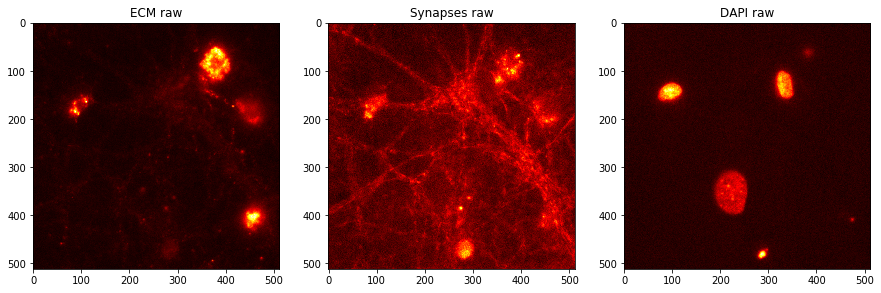

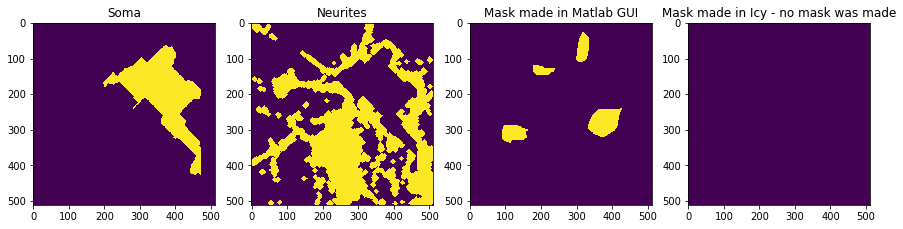

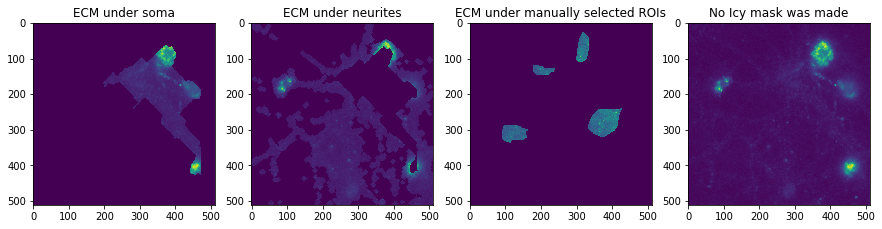

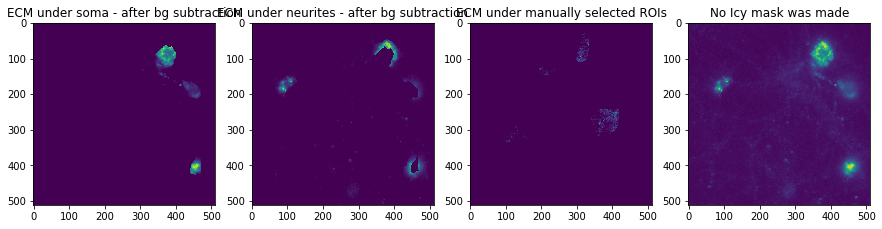

In [99]:
flag=False
flagicy=False
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]
soma_mask=results["Soma mask from synapse channel"][randomno]
neurites_mask=results["Neurites mask from synapse channel"][randomno]
matlab_mask=results["Manual mask from matlab GUI"][randomno]
icy_mask=results["Icy spots mask"][randomno]

with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    nuclei_image=images[nuclei_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    ###the part below just checks what filter was used in the microscope for the channels
    ###from the image metadata
    [channel1name, channel2name, channel3name]=ecm_image.metadata['channels']
    if ecm_channel_no==1:
        ecm_channelname=channel1name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel3name
        else:
            nuclei_channelname=channel3name
            synapse_channelname=channel2name
    if ecm_channel_no==2:
        ecm_channelname=channel2name
        if nuclei_channel_no==3:
            nuclei_channelname=channel3name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel3name
    if ecm_channel_no==3:
        ecm_channelname=channel3name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel2name
            
#make temporary masked images to show what we will keep
ecm_somamasked=deepcopy(ecm_image)
ecm_neuritemasked=deepcopy(ecm_image)
ecm_somamasked[~soma_mask]=0
ecm_neuritemasked[~neurites_mask]=0
ecm_matlabmasked=deepcopy(ecm_image)
synapses_matlabmasked=deepcopy(synapse_image)
ecm_icymasked=deepcopy(ecm_image)
synapses_icymasked=deepcopy(synapse_image)
if type(matlab_mask)==np.ndarray:
    ecm_matlabmasked[~matlab_mask]=0
    synapses_matlabmasked[~matlab_mask]=0
    flag=True
if type(icy_mask)==np.ndarray:
    ecm_icymasked[~icy_mask]=0
    synapses_icymasked[~icy_mask]=0
    flagicy=True

figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
figure.add_subplot(132)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
figure.add_subplot(133)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')

#show masks
fig=plt.figure(figsize=(15,15))
fig.add_subplot(141)
plt.imshow(soma_mask)
plt.title('Soma')
fig.add_subplot(142)
plt.imshow(neurites_mask)
plt.title('Neurites')
fig.add_subplot(143)
if flag==True:
    plt.imshow(matlab_mask)
    plt.title('Mask made in Matlab GUI')
else:
    plt.imshow(np.zeros([512,512]))
    plt.title('Mask made in Matlab GUI - no mask was made') 
fig.add_subplot(144)
if flagicy==True:
    plt.imshow(icy_mask)
    plt.title('Mask made in Icy')
else:
    plt.imshow(np.zeros([512,512]))
    plt.title('Mask made in Icy - no mask was made') 
#show masked images
fig=plt.figure(figsize=(15,15))
fig.add_subplot(141)
plt.imshow(ecm_somamasked)
plt.title('ECM under soma')
fig.add_subplot(142)
plt.imshow(ecm_neuritemasked)
plt.title('ECM under neurites')
fig.add_subplot(143)
if flag==True:
    plt.imshow(ecm_matlabmasked)
    plt.title('ECM under manually selected ROIs')
else:
    plt.imshow(ecm_matlabmasked)
    plt.title('No manual mask was made') 
fig.add_subplot(144)
if flagicy==True:
    plt.imshow(ecm_icymasked)
    plt.title('ECM under Icy ROIs')
else:
    plt.imshow(ecm_icymasked)
    plt.title('No Icy mask was made') 
#background subtraction    
bg_somamask=np.mean(ndi.median_filter(ecm_image[soma_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[soma_mask],size=5))
ecm_somamasked_bgreduced=deepcopy(ecm_image)
ecm_somamasked_bgreduced=np.subtract(ecm_somamasked_bgreduced,bg_somamask)
ecm_somamasked_bgreduced[ecm_somamasked_bgreduced<0]=0
ecm_somamasked_bgreduced[~soma_mask]=0
bg_neuritesmask=np.mean(ndi.median_filter(ecm_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[neurites_mask],size=5))
ecm_neuritesmasked_bgreduced=deepcopy(ecm_image)
ecm_neuritesmasked_bgreduced=np.subtract(ecm_neuritesmasked_bgreduced,bg_neuritesmask)
ecm_neuritesmasked_bgreduced[ecm_neuritesmasked_bgreduced<0]=0
ecm_neuritesmasked_bgreduced[~neurites_mask]=0
ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
ecm_icymasked_bgreduced=deepcopy(ecm_image)
if flag==True:
    bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
    ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
    ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
    ecm_matlabmasked_bgreduced[~matlab_mask]=0
if flagicy==True:
    bg_icymask=np.mean(ndi.median_filter(ecm_image[icy_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[icy_mask],size=5))
    ecm_icymasked_bgreduced=np.subtract(ecm_icymasked_bgreduced,bg_icymask)
    ecm_icymasked_bgreduced[ecm_icymasked_bgreduced<0]=0
    ecm_icymasked_bgreduced[~icy_mask]=0

#show bg subtracted masked images
fig=plt.figure(figsize=(15,15))
fig.add_subplot(141)
plt.imshow(ecm_somamasked_bgreduced)
plt.title('ECM under soma - after bg subtraction')
fig.add_subplot(142)
plt.imshow(ecm_neuritesmasked_bgreduced)
plt.title('ECM under neurites - after bg subtraction')
fig.add_subplot(143)
if flag==True:
    plt.imshow(ecm_matlabmasked_bgreduced)
    plt.title('ECM under manually selected ROIs')
else:
    plt.imshow(ecm_matlabmasked_bgreduced)
    plt.title('No manual mask was made')
fig.add_subplot(144)
if flagicy==True:
    plt.imshow(ecm_icymasked_bgreduced)
    plt.title('ECM under Icy ROIs')
else:
    plt.imshow(ecm_icymasked_bgreduced)
    plt.title('No Icy mask was made')

<a id='quantitativeimageanalysis'></a> 
### Quanitative image analysis

Now we can extract some numbers from our processed images. We'll extract a lot of data - you never know what could be interesting, and we don't have to use it all.

Beforehand, we will calculate the mean intensity of the non-blocked control images, so that we can use this later in the analysis

In [100]:
blockingpaths=np.unique(results["noblock_controldir"])

In [101]:
ctrlecms={"filename":[]}
blockingpaths=np.unique(results["noblock_controldir"])

for p in range(0,len(blockingpaths)):
    pathecm=str(blockingpaths[p])
    filelistecm = []
    for root, _, filenames in os.walk(pathecm):
         for filename in filenames:
             filelistecm.append(os.path.join(root, filename)) #make a list of all images in control folder
    for l in range(0,len(filelistecm)):
        if filelistecm[l].endswith(".nd2"): 
            ctrlecms["filename"].append(filelistecm[l])

ecmcolour_ctrls=np.zeros((len(ctrlecms["filename"]),1)) #make empty vector to store mean intensity of each image
ecmcolour_somamasked_ctrls=np.zeros((len(ctrlecms["filename"]),1))
ecmcolour_neuritesmasked_ctrls=np.zeros((len(ctrlecms["filename"]),1))


for im in range(0,len(ctrlecms["filename"])):
    with ND2Reader(ctrlecms["filename"][im]) as images:
        ecm_image_ctrl=images[ecm_channel_no-1]
    #convert to array
    ecm_image_ctrl=ecm_image_ctrl.astype(np.int16)
    #normalize intensity to value between 0 and 1
    ecm_image_ctrl=np.divide(ecm_image_ctrl,16383.)
    #append raw mean intensity to vector
    ecmcolour_ctrls[im]=np.nanmean(ecm_image_ctrl)
    ##### calculate the intensity for the masked images separately #########
    soma_mask=results["Soma mask from synapse channel"][im]
    neurites_mask=results["Neurites mask from synapse channel"][im]
    ecmcolour_somamasked_ctrls[im]=np.nanmean(ecm_image_ctrl[soma_mask])
    ecmcolour_neuritesmasked_ctrls[im]=np.nanmean(ecm_image_ctrl[neurites_mask])

#average the vectors
ecm_ctrl_mean=np.nanmean(ecmcolour_ctrls)
ecm_somamasked_ctrl_mean=np.nanmean(ecmcolour_somamasked_ctrls)
ecm_neuritesmasked_ctrl_mean=np.nanmean(ecmcolour_neuritesmasked_ctrls)

### **Now we can run the analysis in a loop over all the images**

This will take a while...

In [102]:
print('Total number of images: ' + str(len(results['filename'])))
flag=False
flagicy=False
for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]
    nuclei_channel_no=results["nucleichannelno"][i]
    synapse_channel_no=results["synapsechannelno"][i]
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[ecm_channel_no-1]
        nuclei_image=images[nuclei_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    nuclei_image=nuclei_image.astype(np.int16)
    synapse_image=synapse_image.astype(np.int16)
    
    ###################analyses for the raw images -before processing##############
    #preserve the raw images
    ecm_image_raw = deepcopy(ecm_image)
    nuclei_image_raw=deepcopy(nuclei_image)
    synapse_image_raw=deepcopy(synapse_image)
    #normalize intensity to value between 0 and 1 - also just to make them easier to work with
    ecm_image=np.divide(ecm_image,16383.)
    nuclei_image=np.divide(nuclei_image,16383.)
    synapse_image=np.divide(synapse_image,16383.)
    #read masks
    soma_mask=results["Soma mask from synapse channel"][i]
    neurites_mask=results["Neurites mask from synapse channel"][i]
    matlab_mask=results["Manual mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    icy_mask=results["Icy spots mask"][i]
    if type(icy_mask)==np.ndarray:
        flagicy=True
    #images after background subtraction
    #for ecm image
    bg_somamask=np.mean(ndi.median_filter(ecm_image[soma_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[soma_mask],size=5))
    ecm_somamasked_bgreduced=deepcopy(ecm_image)
    ecm_somamasked_bgreduced=np.subtract(ecm_somamasked_bgreduced,bg_somamask)
    ecm_somamasked_bgreduced[ecm_somamasked_bgreduced<0]=0
    ecm_somamasked_bgreduced[~soma_mask]=0
    bg_neuritesmask=np.mean(ndi.median_filter(ecm_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[neurites_mask],size=5))
    ecm_neuritesmasked_bgreduced=deepcopy(ecm_image)
    ecm_neuritesmasked_bgreduced=np.subtract(ecm_neuritesmasked_bgreduced,bg_neuritesmask)
    ecm_neuritesmasked_bgreduced[ecm_neuritesmasked_bgreduced<0]=0
    ecm_neuritesmasked_bgreduced[~neurites_mask]=0
    ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
    ecm_icymasked_bgreduced=deepcopy(ecm_image)
    if flag==True:
        bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
    if flagicy==True:
        bg_icymask=np.mean(ndi.median_filter(ecm_image[icy_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[icy_mask],size=5))
        ecm_icymasked_bgreduced=np.subtract(ecm_icymasked_bgreduced,bg_icymask)
        ecm_icymasked_bgreduced[ecm_icymasked_bgreduced<0]=0
        ecm_icymasked_bgreduced[~icy_mask]=0
    #for synapse image
    bg_somamask=np.mean(ndi.median_filter(synapse_image[soma_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[soma_mask],size=5))
    synapse_somamasked_bgreduced=deepcopy(synapse_image)
    synapse_somamasked_bgreduced=np.subtract(synapse_somamasked_bgreduced,bg_somamask)
    synapse_somamasked_bgreduced[synapse_somamasked_bgreduced<0]=0
    synapse_somamasked_bgreduced[~soma_mask]=0
    bg_neuritesmask=np.mean(ndi.median_filter(synapse_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[neurites_mask],size=5))
    synapse_neuritesmasked_bgreduced=deepcopy(synapse_image)
    synapse_neuritesmasked_bgreduced=np.subtract(synapse_neuritesmasked_bgreduced,bg_neuritesmask)
    synapse_neuritesmasked_bgreduced[synapse_neuritesmasked_bgreduced<0]=0
    synapse_neuritesmasked_bgreduced[~neurites_mask]=0
    synapse_matlabmasked_bgreduced=deepcopy(synapse_image)
    synapse_icymasked_bgreduced=deepcopy(synapse_image)
    if flag==True:
        bg_matlabmask=np.mean(ndi.median_filter(synapse_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[matlab_mask],size=5))
        synapse_matlabmasked_bgreduced=np.subtract(synapse_matlabmasked_bgreduced,bg_matlabmask)
        synapse_matlabmasked_bgreduced[synapse_matlabmasked_bgreduced<0]=0
        synapse_matlabmasked_bgreduced[~matlab_mask]=0
    if flagicy==True:
        bg_icymask=np.mean(ndi.median_filter(synapse_image[icy_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[icy_mask],size=5))
        synapse_icymasked_bgreduced=np.subtract(synapse_icymasked_bgreduced,bg_icymask)
        synapse_icymasked_bgreduced[synapse_icymasked_bgreduced<0]=0
        synapse_icymasked_bgreduced[~icy_mask]=0
    #make raw ecm images normalized to the raw intensity of the non-blocked controls 
    ecm_image_normtoctrl=deepcopy(ecm_image)
    ecm_image_normtoctrl=np.divide(ecm_image_normtoctrl,ecm_ctrl_mean)
    #make histograms of the raw images
    ecm_hist,_ = np.histogram(ecm_image,bins=np.linspace(0.,1.,50))
    nuclei_hist,_ = np.histogram(nuclei_image,bins=np.linspace(0.,1.,50))
    synapse_hist,_ = np.histogram(synapse_image,bins=np.linspace(0.,1.,50))
    ##################################################################################    

#append the final results to the dictionary:
    #results based on calculation on raw images
    results["ECM raw intensity, unmasked"].append(np.nanmean(ecm_image_raw))
    results["Nuclei raw intensity, unmasked"].append(np.nanmean(nuclei_image_raw))
    results["Synapse raw intensity, unmasked"].append(np.nanmean(synapse_image_raw))
    results["ECM intensity: unmasked, divded by unblocked condition"].append(np.nanmean(ecm_image_normtoctrl))
    histogram_results["ECM raw intensity- Flattened histogram"].append(ecm_hist) 
    histogram_results["Nuclei raw intensity- Flattened histogram"].append(nuclei_hist)
    histogram_results["Synapse raw intensity- Flattened histogram"].append(synapse_hist)
    #results under mask
    results["ECM mean intensity: soma only"].append(np.nanmean(ecm_image[soma_mask]))
    results["ECM mean intensity: soma only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[soma_mask]))
    results["ECM mean intensity: neurites only"].append(np.nanmean(ecm_image[neurites_mask]))
    results["ECM mean intensity: neurites only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[neurites_mask]))
    if flag==True:
        results["ECM mean intensity: matlab manual mask only"].append(np.nanmean(ecm_image[matlab_mask]))
        results["ECM mean intensity: matlab manual mask only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[matlab_mask]))
    else:
        results["ECM mean intensity: matlab manual mask only"].append(np.nan)
        results["ECM mean intensity: matlab manual mask only, divided by unblocked"].append(np.nan)
    if flagicy==True:
        results["ECM mean intensity: icy  mask only"].append(np.nanmean(ecm_image[icy_mask]))
        results["ECM mean intensity: icy mask only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[icy_mask]))
    else:
        results["ECM mean intensity: icy  mask only"].append(np.nan)
        results["ECM mean intensity: icy mask only, divided by unblocked"].append(np.nan)
    results["Synapse mean intensity: soma only"].append(np.nanmean(synapse_image[soma_mask]))
    results["Synapse mean intensity: neurites only"].append(np.nanmean(synapse_image[neurites_mask]))
    if flag==True:
        results["Synapse mean intensity: matlab manual mask only"].append(np.nanmean(synapse_image[matlab_mask]))
    else:
        results["Synapse mean intensity: matlab manual mask only"].append(np.nan)
    if flagicy==True:
        results["Synapse mean intensity: icy mask only"].append(np.nanmean(synapse_image[icy_mask]))
    else:
        results["Synapse mean intensity: icy mask only"].append(np.nan)
    results["Nuclei mean intensity: soma only"].append(np.nanmean(nuclei_image[soma_mask]))
    results["Nuclei mean intensity: neurites only"].append(np.nanmean(nuclei_image[neurites_mask]))
    if flag==True:
        results["Nuclei mean intensity: matlab manual mask only"].append(np.nanmean(nuclei_image[neurites_mask]))
    else:
        results["Nuclei mean intensity: matlab manual mask only"].append(np.nan)
    if flagicy==True:
        results["Nuclei mean intensity: icy mask only"].append(np.nanmean(nuclei_image[neurites_mask]))
    else:
        results["Nuclei mean intensity: icy mask only"].append(np.nan)        
    synapse_image_threshold=threshold_li(synapse_image)
    synapse_image_thresholded=deepcopy(synapse_image)
    synapse_image_thresholded[synapse_image_thresholded<synapse_image_threshold]=0
    synapse_soma=deepcopy(synapse_image_thresholded)
    synapse_soma[~soma_mask]=0
    synapse_neurites=deepcopy(synapse_image_thresholded)
    synapse_neurites[~neurites_mask]=0
    synapse_labeled_mask_soma, cc_num_soma = ndi.label(synapse_soma)
    synapse_labeled_mask_neurites, cc_num_neurites = ndi.label(synapse_neurites)
    results["Number of synapse spots in soma mask"].append(cc_num_soma)
    results["Number of synapse spots in neurites mask"].append(cc_num_neurites)
    if flag==True:
        synapse_matlab=deepcopy(synapse_image_thresholded)
        synapse_matlab[~matlab_mask]=0
        synapse_labeled_mask_matlab, cc_num_matlab = ndi.label(synapse_matlab)
        results["Number of synapse spots in matlab manual mask"].append(cc_num_matlab)
    else:
        results["Number of synapse spots in matlab manual mask"].append(np.nan)
    if flagicy==True:
        synapse_icy=deepcopy(synapse_image_thresholded)
        synapse_icy[~icy_mask]=0
        synapse_labeled_mask_icy, cc_num_icy = ndi.label(synapse_icy)
        results["Number of synapse spots in icy mask"].append(cc_num_icy)
    else:
        results["Number of synapse spots in icy mask"].append(np.nan)    
    nuclei_image_threshold=threshold_li(nuclei_image)
    nuclei_image_thresholded=deepcopy(nuclei_image)
    nuclei_image_thresholded[nuclei_image_thresholded<nuclei_image_threshold]=0
    nuclei_soma=deepcopy(nuclei_image_thresholded)
    nuclei_soma[~soma_mask]=0
    nuclei_neurites=deepcopy(nuclei_image_thresholded)
    nuclei_neurites[~neurites_mask]=0
    nuclei_labeled_mask_soma, cc_num_soma = ndi.label(nuclei_soma)
    nuclei_labeled_mask_neurites, cc_num_neurites = ndi.label(nuclei_neurites)
    results["Number of nuclei spots in soma mask"].append(cc_num_soma)
    results["Number of nuclei spots in neurites mask"].append(cc_num_neurites)
    if flag==True:
        nuclei_matlab=deepcopy(nuclei_image_thresholded)
        nuclei_matlab[~matlab_mask]=0
        nuclei_labeled_mask_matlab, cc_num_matlab = ndi.label(nuclei_matlab)
        results["Number of nuclei spots in matlab manual mask"].append(cc_num_matlab)
    else:
        results["Number of nuclei spots in matlab manual mask"].append(np.nan)
    if flagicy==True:
        nuclei_icy=deepcopy(nuclei_image_thresholded)
        nuclei_icy[~icy_mask]=0
        nuclei_labeled_mask_icy, cc_num_icy = ndi.label(nuclei_icy)
        results["Number of nuclei spots in icy mask"].append(cc_num_icy)
    else:
        results["Number of nuclei spots in icy mask"].append(np.nan)
    #results after background subtraction
    results["ECM mean intensity after bg subtraction: soma only"].append(np.nanmean(ecm_somamasked_bgreduced[soma_mask]))
    results["ECM mean intensity after bg subtraction: soma only, divided by unblocked"].append(np.divide(np.nanmean(ecm_somamasked_bgreduced[soma_mask]),ecm_ctrl_mean))
    results["ECM mean intensity after bg subtraction: neurites only"].append(np.nanmean(ecm_neuritesmasked_bgreduced[neurites_mask]))
    results["ECM mean intensity after bg subtraction: neurites only, divided by unblocked"].append(np.divide(np.nanmean(ecm_neuritesmasked_bgreduced[neurites_mask]),ecm_ctrl_mean))
    if flag==True:
        results["ECM mean intensity after bg subtraction: matlab manual mask only"].append(np.nanmean(ecm_matlabmasked_bgreduced[matlab_mask]))
        results["ECM mean intensity after bg subtraction: matlab manual mask only, divided by unblocked"].append(np.divide(np.nanmean(ecm_matlabmasked_bgreduced[matlab_mask]),ecm_ctrl_mean))
    else:
        results["ECM mean intensity after bg subtraction: matlab manual mask only"].append(np.nan)
        results["ECM mean intensity after bg subtraction: matlab manual mask only, divided by unblocked"].append(np.nan)
    if flagicy==True:
        results["ECM mean intensity after bg subtraction: icy mask only"].append(np.nanmean(ecm_icymasked_bgreduced[icy_mask]))
        results["ECM mean intensity after bg subtraction: icy mask only, divided by unblocked"].append(np.divide(np.nanmean(ecm_icymasked_bgreduced[icy_mask]),ecm_ctrl_mean))
    else:
        results["ECM mean intensity after bg subtraction: icy mask only"].append(np.nan)
        results["ECM mean intensity after bg subtraction: icy mask only, divided by unblocked"].append(np.nan)
    results["Synapse mean intensity after bg subtraction: soma only"].append(np.nanmean(synapse_somamasked_bgreduced[soma_mask]))
    results["Synapse mean intensity after bg subtraction: neurites only"].append(np.nanmean(synapse_neuritesmasked_bgreduced[neurites_mask]))
    if flag==True:
        results["Synapse mean intensity after bg subtraction: matlab manual mask only"].append(np.nanmean(synapse_matlabmasked_bgreduced[matlab_mask]))
    else:
        results["Synapse mean intensity after bg subtraction: matlab manual mask only"].append(np.nan)
    if flagicy==True:
        results["Synapse mean intensity after bg subtraction: icy mask only"].append(np.nanmean(synapse_icymasked_bgreduced[icy_mask]))
    else:
        results["Synapse mean intensity after bg subtraction: icy mask only"].append(np.nan)
    synapse_soma=deepcopy(synapse_somamasked_bgreduced)
    synapse_neurites=deepcopy(synapse_neuritesmasked_bgreduced)
    synapse_soma[~soma_mask]=0
    synapse_neurites[~neurites_mask]=0
    synapse_labeled_mask_soma, cc_num_soma = ndi.label(synapse_soma)
    synapse_labeled_mask_neurites, cc_num_neurites = ndi.label(synapse_neurites)
    results["Number of synapse spots in soma mask after bg subtraction"].append(cc_num_soma)
    results["Number of synapse spots in neurites mask after bg subtraction"].append(cc_num_neurites)
    if flag==True:
        synapse_matlab=deepcopy(synapse_matlabmasked_bgreduced)
        synapse_matlab[~matlab_mask]=0
        synapse_labeled_mask_matlab, cc_num_matlab = ndi.label(synapse_matlab)
        results["Number of synapse spots in matlab manual mask after bg subtraction"].append(cc_num_matlab)
    else:
        results["Number of synapse spots in matlab manual mask after bg subtraction"].append(np.nan)
    if flagicy==True:
        synapse_icy=deepcopy(synapse_icymasked_bgreduced)
        synapse_icy[~icy_mask]=0
        synapse_labeled_mask_icy, cc_num_icy = ndi.label(synapse_icy)
        results["Number of synapse spots in icy mask after bg subtraction"].append(cc_num_icy)
    else:
        results["Number of synapse spots in icy mask after bg subtraction"].append(np.nan)
    nuclei_image_threshold=threshold_li(nuclei_image)
    nuclei_image_thresholded=deepcopy(nuclei_image)
    nuclei_image_thresholded[nuclei_image_thresholded<nuclei_image_threshold]=0
    nuclei_soma=deepcopy(nuclei_image_thresholded)
    nuclei_soma[~soma_mask]=0
    nuclei_neurites=deepcopy(nuclei_image_thresholded)
    nuclei_neurites[~neurites_mask]=0
    nuclei_labeled_mask_soma, cc_num_soma = ndi.label(nuclei_soma)
    nuclei_labeled_mask_neurites, cc_num_neurites = ndi.label(nuclei_neurites)
    results["Number of nuclei spots in soma mask after bg subtraction"].append(cc_num_soma)
    results["Number of nuclei spots in neurites mask after bg subtraction"].append(cc_num_neurites)
    if flag==True:
        nuclei_matlab=deepcopy(nuclei_image_thresholded)
        nuclei_matlab[~matlab_mask]=0
        nuclei_labeled_mask_matlab, cc_num_matlab = ndi.label(nuclei_matlab)
        results["Number of nuclei spots in matlab manual mask after bg subtraction"].append(cc_num_matlab)
    else:
        results["Number of nuclei spots in matlab manual mask after bg subtraction"].append(np.nan)
    if flagicy==True:
        nuclei_icy=deepcopy(nuclei_image_thresholded)
        nuclei_icy[~icy_mask]=0
        nuclei_labeled_mask_icy, cc_num_icy = ndi.label(nuclei_icy)
        results["Number of nuclei spots in icy mask after bg subtraction"].append(cc_num_icy)
    else:
        results["Number of nuclei spots in icy mask after bg subtraction"].append(np.nan)
    
    #save the region properties of the spots masks, for future analysis
    synapseprops_soma=skimage.measure.regionprops(synapse_labeled_mask_soma)   
    synapseprops_neurites=skimage.measure.regionprops(synapse_labeled_mask_neurites)                                                                             
    regionprops_results["Synapse colour - regionprops soma"].append(synapseprops_soma)
    regionprops_results["Synapse colour - regionprops neurites"].append(synapseprops_neurites)
    clear_output()
    flag=False
os.system('say "Finished batch analyzing"')
print('Done!')

Done!


<a id='plots'></a> 
## Visualization - plots

Now we can make some plots from our data to understand the results. To do this we will first convert our results dictionary into a python *DataFrame*. This is a format used in the Python package Pandas, and it's very handy for data analysis and plotting. It's similar to a spreadsheet (e.g. Excel), except that each cell can hold any type of data you want, even matrices.

In [103]:
df=pd.DataFrame(results)
df['expname']=filelist[i].split("/")[:-2][-1]#add exp id
#dfhists=pd.DataFrame(histogram_results)
#dfregionprops=pd.DataFrame(regionprops_results)

Before continuing, we will make a new folder called 'results' inside our experiment folder, and backup the dataframes as csv (comma separated value) files:

In [104]:
#os.mkdir(expdir+protein+'_results/')
expname=filelist[i].split("/")[:-2][-1]
df.to_csv(path_or_buf=expdir+protein+'_results/results_'+str(protein)+'.csv')
#dfhists.to_csv(path_or_buf=expdir+protein+'_results/histogram_results_'+str(protein)+'.csv')
#dfregionprops.to_csv(path_or_buf=expdir+protein+'_results/regionprops_results_'+str(protein)+'.csv')

**Load an existing DataFrame**
If we want to plot the results that we already created and saved, we can load the csv file and convert it back into a DataFrame:

In [ ]:
#df=pd.read_csv(expdir+protein+'_results/results_'+str(protein)+'.csv')
df=pd.read_csv(expdir+protein+'_results/results_'+str(protein)+'.csv')
#dfhists=pd.read_csv(expdir+'results/histogram_results.csv')
#dfregionprops=pd.read_csv(expdir+'results/regionprops_results.csv')

<a id='checknormality'></a> 
**How does the intensity distribute?**

In [ ]:
variable="ECM raw intensity, unmasked" #change me

x=df[variable].values
normdvar=(x-x.mean())/x.std()
print(type(normdvar))

import scipy.stats as ss
[_,pval]=ss.kstest(normdvar,'norm')
if pval<0.05:
    print("The variable does not distribute normally")
else:
    print("The variable distributes normally")

    sns.set(font_scale=1)
fig=plt.figure(figsize=(10,5))
fig.add_subplot(121)
sns.kdeplot(df[variable],legend=False)
plt.title('Distribution of all conditions')
fig.add_subplot(122)
for condition in list(set(df["exp condition"])):
    sns.kdeplot(df[df["exp condition"]==condition][variable],legend=False)
    
    plt.legend(list(set(df["exp condition"])),loc='upper right')
    plt.title('Individual distribution of conditions')
    

#### Defining variables to plot from dataframe

In [ ]:
vars2plot=df._get_numeric_data().columns #gives the names of the numeric columns only

<a id='barplots'></a> 
**Bar plots**

In [ ]:
plotorder=['2hrs_Bic','2hrs_DMSO','4hrs_Bic','4hrs_DMSO','12hrs_Bic','12hrs_DMSO','Ctrl_NoBlocking']
df_to_plot=df
from matplotlib.backends.backend_pdf import PdfPages
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()
sns.set(font_scale=1.3)
sns.set_palette("GnBu_d")
sns.set_style("whitegrid")
sns.set_context("talk")
for var2plot in vars2plot:
    if not "channelno" in str(var2plot):
        fig=plt.figure(figsize=(10,5))
        d=sns.barplot(y=var2plot,x="exp condition",data=df_to_plot,order=plotorder,linewidth=5,errcolor=".2", edgecolor=".2",errwidth=5)
        d.grid(False)
        d.set_xticklabels(d.get_xticklabels(),rotation=45)
        plt.title('No outlier removal')

<a id='boxwhisker'></a> 
**Box and whisker plots**

A more 'correct' way to plot this would be with box-and-whisker plots. Here the midline represents the median (which is more correct for comparing non-normal data), the edges of the box are the 25th and 75th quantiles, and the edges of the whiskers are the minimum and maximum values:

In [ ]:
plotorder=['2hrs_Bic','2hrs_DMSO','4hrs_Bic','4hrs_DMSO','12hrs_Bic','12hrs_DMSO','Ctrl_NoBlocking']
df_to_plot=df
sns.set(font_scale=1.3)
sns.set_palette("Set2")
sns.set_style("whitegrid")
for var2plot in vars2plot:
    if not "channelno" in str(var2plot):
        fig=plt.figure(figsize=(20,5))
        fig.add_subplot(121)
        d=sns.boxplot(y=var2plot,x="exp condition",data=df_to_plot,order=plotorder,linewidth=4)
        d.grid(False)
        d.set_xticklabels(d.get_xticklabels(),rotation=45)
        plt.title(var2plot, y=1.05, fontsize = 14)
        d.set_ylabel('')

<a id='violinplots'></a> 
**Violin plots**

In [ ]:
sns.set(font_scale=1.2)
sns.set_palette("Set2")
sns.set_style("whitegrid")
for var2plot in vars2plot:
    if not "channelno" in str(var2plot):
        if not "Unnamed" in str(var2plot):
            fig=plt.figure()
            d=sns.violinplot(y=var2plot,x="exp condition",data=df_to_plot)
            d.set_xticklabels(d.get_xticklabels(),rotation=45)
            plt.title(var2plot, y=1.05, fontsize = 14)
            plt.locator_params(axis='y', nbins=5)
            d.set_ylabel('') 
            d.grid(False)
            

<a id='makingsense'></a> 
### Making sense

Let's add some human-understandable tags to the DataFrame, so that we can plot what we want more easily.
- A tag for the incubation time
- A tag for the treatment condition (Bic/DMSO)

In [ ]:
df2=deepcopy(df)
df2['Time']='None'
df2.loc[df2['exp condition'].str.contains('2hr'), 'Time'] = '2hrs'
df2.loc[df2['exp condition'].str.contains('12hrs'), 'Time'] = '12hrs'
df2.loc[df2['exp condition'].str.contains('4hrs'), 'Time'] = '4hrs'
df2.loc[df2['exp condition'].str.contains('22hrs'), 'Time'] = '22hrs'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Time'] = 'Unblocked Control'
df2.loc[df2['exp condition'].str.contains('Bic'), 'Drug'] = 'Bic'
df2.loc[df2['exp condition'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
#nicely written treatment condition for plotting
df2['Condition']='None'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Condition'] = 'Unblocked Control'
df2.loc[df2['exp condition'].str.contains('2hrs_Bic'), 'Condition'] = '2hr + Bic'
df2.loc[df2['exp condition'].str.contains('2hrs_DMSO'), 'Condition'] = '2hr'
df2.loc[df2['exp condition'].str.contains('4hrs_Bic'), 'Condition'] = '4hr + Bic'
df2.loc[df2['exp condition'].str.contains('4hrs_DMSO'), 'Condition'] = '4hr'
df2.loc[df2['exp condition'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df2.loc[df2['exp condition'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr'

**Bic versus DMSO Pointplot across time**

We can also plot the mean intensity as a function of time using a point plot. Let's do this separately for the different treatments:

In [ ]:
orderlab=['2hrs','4hrs','12hrs']
sns.set(font_scale=1)
sns.set_palette("Paired", 2)
sns.set_style("whitegrid")
for var2plot in vars2plot:
    if not "channelno" in str(var2plot):
        if not "Unnamed" in str(var2plot):
            fig=plt.figure()
            d=sns.pointplot(y=var2plot, x='Time',data=df2[df2["Drug"]!="None"],hue='Drug',
                            hue_order=['DMSO','Bic'],split=True,order=orderlab,ci=None)
            plt.title(var2plot, y=1.05, fontsize = 14)
            d.set_ylabel('') 
            plt.locator_params(axis='y', nbins=5)
            d.grid(False)
            plt.errorbar(x=[0,1,2],
                     y=[df2[(df2["Drug"]=="Bic")&(df2["Time"]=="2hrs")][var2plot].mean(),
                        df2[(df2["Drug"]=="Bic")&(df2["Time"]=="4hrs")][var2plot].mean(),
                            df2[(df2["Drug"]=="Bic")&(df2["Time"]=="12hrs")][var2plot].mean()],
                            yerr=[df2[(df2["Drug"]=="Bic")&(df2["Time"]=="2hrs")][var2plot].sem(),
                                  df2[(df2["Drug"]=="Bic")&(df2["Time"]=="4hrs")][var2plot].sem(),
                            df2[(df2["Drug"]=="Bic")&(df2["Time"]=="12hrs")][var2plot].sem()],
                            xerr=None,ecolor='dodgerblue',fmt='none',capsize=2)
            plt.errorbar(x=[0,1,2],
                      y=[df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="2hrs")][var2plot].mean(),
                         df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="4hrs")][var2plot].mean(),
                            df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="12hrs")][var2plot].mean()],
                            yerr=[df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="2hrs")][var2plot].sem(),
                                  df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="4hrs")][var2plot].sem(),
                            df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="12hrs")][var2plot].sem()],
                            xerr=None,ecolor='lightblue',fmt='none',capsize=2)
            #d.set_yscale('log')

#### Bic-versus-DMSO boxplot across time

In [ ]:
orderlab=['2hrs','4hrs','12hrs']
sns.set(font_scale=1.3)
sns.set_palette("Paired", 2)
sns.set_style("whitegrid")
sns.despine()
for var2plot in vars2plot:
    if not 'channelno' in str(var2plot):
        fig=plt.figure(figsize=(20,5))
        fig.add_subplot(121)
        d=sns.boxplot(y=var2plot,x="Time",data=df2,linewidth=4,hue="Drug",order=orderlab)
        d.grid(False)
        d.set_yscale('log')
        plt.title('No outlier removal')
        fig.add_subplot(122)
        data_noout=remove_outlier(df2,var2plot)
        d=sns.boxplot(y=var2plot,x="Time",data=data_noout,linewidth=4,hue="Drug",order=orderlab)
        c
        plt.title('With outlier removal')

## Boxplots for matlab masked ROIs: general increase, and split by treatment

In [ ]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
sns.despine()
sns.set_palette("Set2")
df_to_plot=df2
hueselector=None
x_labels="Time"
y_axis="ECM mean intensity after bg subtraction: icy mask only"
plot_order=["2hrs","4hrs","12hrs", "Unblocked Control"]   
#plot
fig=plt.figure(figsize=(28,14))
fig.add_subplot(121)
d=sns.boxplot(y=y_axis,x=x_labels,data=df_to_plot,linewidth=7,
              hue=hueselector,order=plot_order,hue_order=['Bic','DMSO'],width=0.4)
d.set_ylim([0.8*df_to_plot[y_axis].min(), 0.75*df_to_plot[y_axis].max()])
d.set_xticklabels(d.get_xticklabels(),rotation=45,weight='bold',size=28)
plt.title('')
plt.locator_params(axis='y', nbins=5)
d.set_ylabel('Fluorescence Intensity (AU)',weight='bold',size=28,labelpad=65)
d.set_xlabel('')
d.grid(False)
fig.add_subplot(122)
sns.set_palette("Paired", 2)
df_to_plot=df2[df2["Time"]!="None"]
hueselector="Drug"
x_labels="Time"
plot_order=["2hrs","4hrs","12hrs"]    
g=sns.boxplot(y=y_axis,x=x_labels,data=df_to_plot,linewidth=5,hue=hueselector,order=plot_order,
              hue_order=['Bic','DMSO'],width=0.4)
g.set_xticklabels(g.get_xticklabels(),rotation=45,weight='bold',size=28)
plt.legend(fontsize=38)
plt.title('')
plt.locator_params(axis='y', nbins=5)
plt.yticks(visible=False)
g.set_ylabel('')
g.set_xlabel('')
g.grid(False)
#statistics
df_to_plot=df2[df2["Time"]!="None"]
#3 t tests with bonferonni
counter=-0.2
for timepoint in plot_order:
    untreated=df_to_plot[(df_to_plot["Time"]==timepoint)&(df_to_plot["Drug"]=="DMSO")][y_axis]
    bic=df_to_plot[(df_to_plot["Time"]==timepoint)&(df_to_plot["Drug"]=="Bic")][y_axis]
    [stat,pval]=stats.ttest_ind(untreated, bic)
    #bonferroni correction, but divide by 2 for directional ttest
    pval=pval*len(np.unique(df_to_plot["Time"]))/2
    #plot
    x1, x2 = counter, counter+0.4 
    y= 1.05*df_to_plot[df_to_plot["Time"]==timepoint][y_axis].max()
    h=0.05*df_to_plot[df_to_plot["Time"]==timepoint][y_axis].max()
    col='k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
    if pval<0.001:
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=28, weight='bold')
    elif pval<0.01:
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=28, weight='bold')
    elif pval<0.05:
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
    else:
        plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=28, weight='bold')
        counter+=1